# vidqc Model Performance Report

This notebook presents a comprehensive performance analysis of the vidqc XGBoost artifact classifier.
It uses cached features to avoid re-running OCR extraction (~100s/clip), making it runnable in seconds.

## 1. Setup & Data Loading

In [1]:
import json
import pickle
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Ensure project root is on path (handle kernel CWD being reports/ or project root)
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "vidqc").exists() and (PROJECT_ROOT.parent / "vidqc").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

from vidqc.config import load_config
from vidqc.eval import check_success_criteria
from vidqc.features.feature_manifest import (
    COMBINED_FEATURE_NAMES,
    TEXT_FEATURE_NAMES,
    TEMPORAL_FEATURE_NAMES,
)
from vidqc.models.classifier import VidQCClassifier

# Visual style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 5)

# Consistent color scheme
CLASS_COLORS = {
    "NONE": "#4CAF50",
    "TEXT_INCONSISTENCY": "#FF9800",
    "TEMPORAL_FLICKER": "#F44336",
}
CLASS_ORDER = ["NONE", "TEXT_INCONSISTENCY", "TEMPORAL_FLICKER"]

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/ulisesrayon/Documents/projects/vidqc


In [2]:
# Load all artifacts
config = load_config(str(PROJECT_ROOT / "config.yaml"))

with open(PROJECT_ROOT / "models" / "training_manifest.json") as f:
    manifest = json.load(f)

with open(PROJECT_ROOT / "models" / "feature_importances.json") as f:
    feature_importances = json.load(f)

labels_df = pd.read_csv(PROJECT_ROOT / "samples" / "labels.csv")

latency_path = PROJECT_ROOT / "reports" / "latency_benchmark.json"
latency_data = None
if latency_path.exists():
    with open(latency_path) as f:
        latency_data = json.load(f)

with open(PROJECT_ROOT / "features_cache.pkl", "rb") as f:
    features_cache = pickle.load(f)

# Load classifier
classifier = VidQCClassifier(config)
classifier.load(str(PROJECT_ROOT / "models" / "model.json"))

print(f"Loaded {len(labels_df)} labeled clips")
print(f"Feature cache has {len(features_cache)} entries")
print(f"Training date: {manifest['training_date']}")
print(f"Feature count: {manifest['num_features']}")

Loaded 30 labeled clips
Feature cache has 30 entries
Training date: 2026-02-12T00:21:13.114423
Feature count: 43


## 2. Dataset Overview

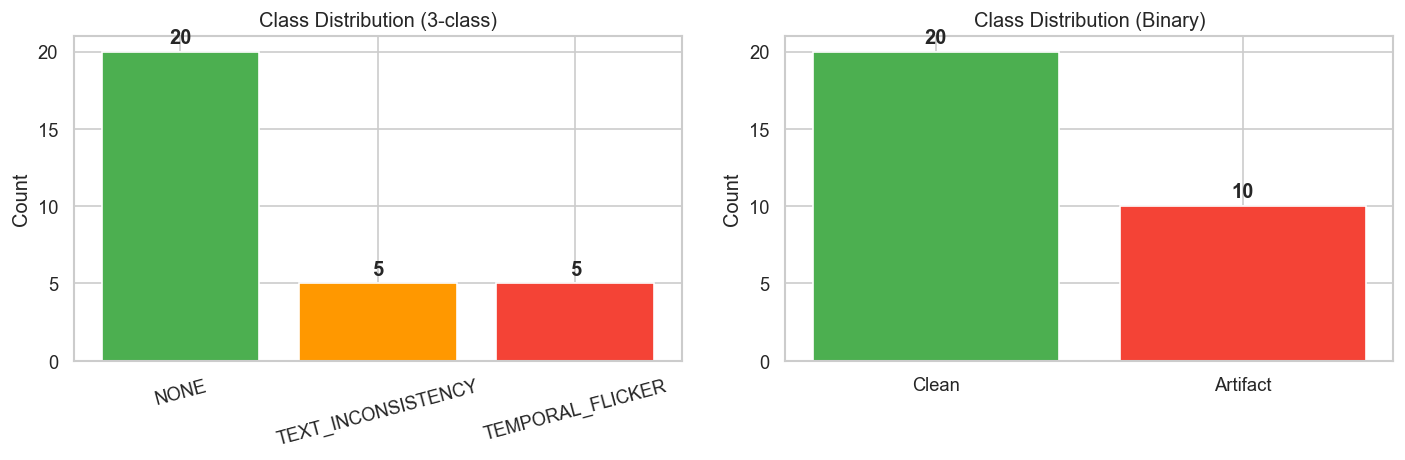

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 3-class distribution
class_counts = labels_df["artifact_category"].value_counts().reindex(CLASS_ORDER).fillna(0)
colors = [CLASS_COLORS[c] for c in class_counts.index]
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor="white")
axes[0].set_title("Class Distribution (3-class)")
axes[0].set_ylabel("Count")
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                 str(int(count)), ha="center", va="bottom", fontweight="bold")
axes[0].tick_params(axis="x", rotation=15)

# Binary distribution
binary_counts = labels_df["artifact"].map({True: "Artifact", "true": "Artifact",
                                            False: "Clean", "false": "Clean"}).value_counts()
binary_colors = ["#F44336" if k == "Artifact" else "#4CAF50" for k in binary_counts.index]
bars = axes[1].bar(binary_counts.index, binary_counts.values, color=binary_colors, edgecolor="white")
axes[1].set_title("Class Distribution (Binary)")
axes[1].set_ylabel("Count")
for bar, count in zip(bars, binary_counts.values):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                 str(int(count)), ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.show()

## 3. Cross-Validation Results

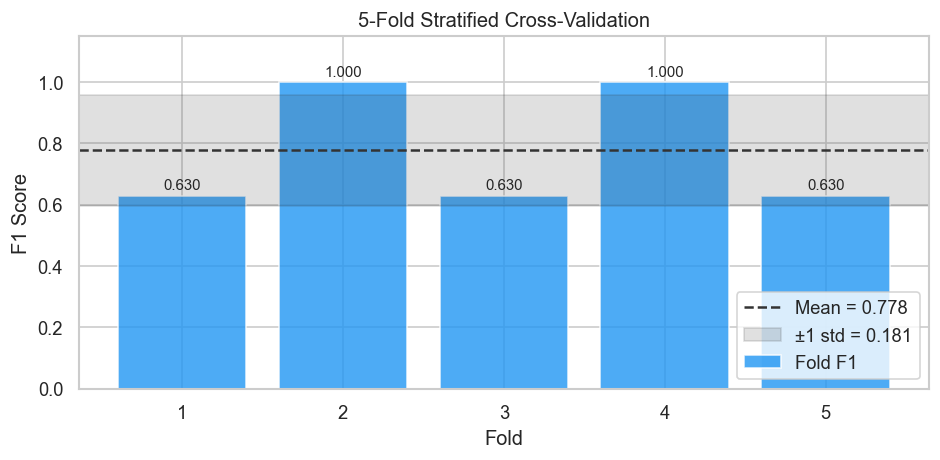

CV Mean F1: 0.7778
CV Std F1:  0.1814


In [4]:
fold_scores = manifest["cv_fold_scores"]
mean_f1 = manifest["cv_mean_f1"]
std_f1 = manifest["cv_std_f1"]

fig, ax = plt.subplots(figsize=(8, 4))
fold_indices = list(range(1, len(fold_scores) + 1))
bars = ax.bar(fold_indices, fold_scores, color="#2196F3", edgecolor="white", alpha=0.8, label="Fold F1")

# Mean line + std band
ax.axhline(mean_f1, color="#333333", linestyle="--", linewidth=1.5, label=f"Mean = {mean_f1:.3f}")
ax.axhspan(mean_f1 - std_f1, mean_f1 + std_f1, alpha=0.15, color="#333333", label=f"\u00b11 std = {std_f1:.3f}")

for bar, score in zip(bars, fold_scores):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f"{score:.3f}", ha="center", va="bottom", fontsize=9)

ax.set_xlabel("Fold")
ax.set_ylabel("F1 Score")
ax.set_title("5-Fold Stratified Cross-Validation")
ax.set_ylim(0, 1.15)
ax.set_xticks(fold_indices)
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"CV Mean F1: {mean_f1:.4f}")
print(f"CV Std F1:  {std_f1:.4f}")

## 4. Full Evaluation: Confusion Matrix & Classification Report

In [5]:
# Run predictions on all clips using cached features
predictions = []
cache_misses = 0

for _, row in labels_df.iterrows():
    video_path = row["path"]
    true_label = row["artifact_category"]

    if video_path in features_cache:
        cached = features_cache[video_path]
        features = cached["features"]
    else:
        # Fallback: extract features (slow)
        from vidqc.features.extract import extract_all_features
        features, _ = extract_all_features(str(PROJECT_ROOT / video_path), config)
        cache_misses += 1

    has_text = bool(features[0] > 0)  # has_text_regions is index 0
    result = classifier.predict(features, has_text)

    predictions.append({
        "clip": video_path,
        "true_label": true_label,
        "pred_label": result.predicted_class,
        "artifact_detected": result.artifact_detected,
        "confidence": result.confidence,
        "P(NONE)": result.probabilities["NONE"],
        "P(TEXT)": result.probabilities["TEXT_INCONSISTENCY"],
        "P(FLICKER)": result.probabilities["TEMPORAL_FLICKER"],
        "override": result.override_reason or "",
    })

pred_df = pd.DataFrame(predictions)
pred_df["correct"] = pred_df["true_label"] == pred_df["pred_label"]

print(f"Predictions complete: {len(pred_df)} clips ({cache_misses} cache misses)")
print(f"Overall accuracy: {pred_df['correct'].mean():.1%}")

Predictions complete: 30 clips (0 cache misses)
Overall accuracy: 100.0%


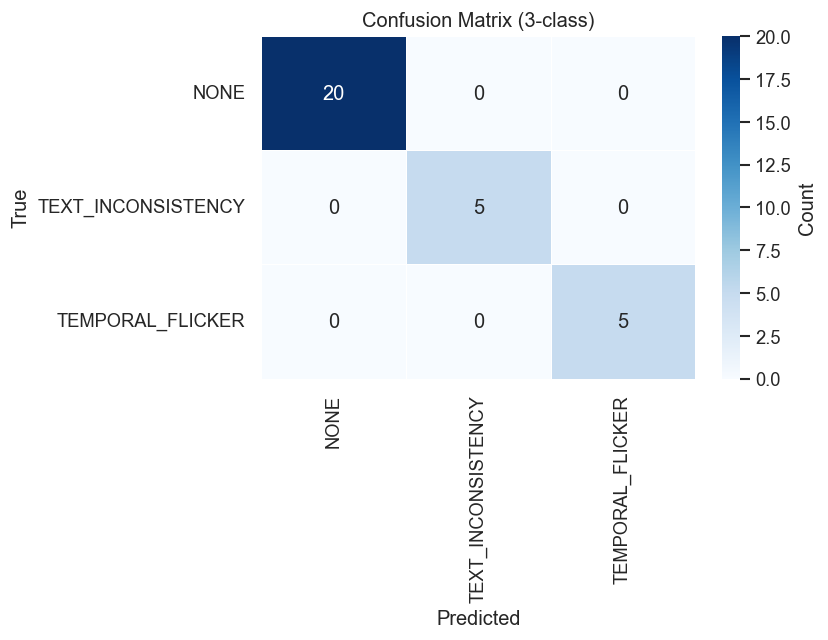

In [6]:
# Confusion matrix heatmap
y_true = pred_df["true_label"].tolist()
y_pred = pred_df["pred_label"].tolist()

cm = confusion_matrix(y_true, y_pred, labels=CLASS_ORDER)

fig, ax = plt.subplots(figsize=(7, 5.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_ORDER, yticklabels=CLASS_ORDER, ax=ax,
            cbar_kws={"label": "Count"}, linewidths=0.5)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (3-class)")
plt.tight_layout()
plt.show()

In [7]:
# Classification report
report = classification_report(y_true, y_pred, labels=CLASS_ORDER, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T

# Display as formatted table
display_df = report_df.loc[CLASS_ORDER + ["macro avg", "weighted avg"]].copy()
display_df["support"] = display_df["support"].astype(int)
display_df[["precision", "recall", "f1-score"]] = display_df[["precision", "recall", "f1-score"]].round(3)

print("Classification Report:")
display(display_df)

Classification Report:


,precision,recall,f1-score,support
NONE,1.0,1.0,1.0,20
TEXT_INCONSISTENCY,1.0,1.0,1.0,5
TEMPORAL_FLICKER,1.0,1.0,1.0,5
macro avg,1.0,1.0,1.0,30
weighted avg,1.0,1.0,1.0,30


## 5. Success Criteria Dashboard

In [8]:
# Compute binary metrics
y_true_binary = [0 if label == "NONE" else 1 for label in y_true]
y_pred_binary = [0 if label == "NONE" else 1 for label in y_pred]

from sklearn.metrics import precision_score, recall_score

binary_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
binary_precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)

text_f1 = report.get("TEXT_INCONSISTENCY", {}).get("f1-score", 0.0)
flicker_f1 = report.get("TEMPORAL_FLICKER", {}).get("f1-score", 0.0)

criteria = check_success_criteria(
    binary_recall, binary_precision, text_f1, flicker_f1,
    cv_std=manifest.get("cv_std_f1")
)

# Build styled criteria table
criteria_rows = []
for key, c in criteria.items():
    if key == "all_passed":
        continue
    criteria_rows.append({
        "Criterion": c["description"],
        "Value": f"{c['value']:.4f}",
        "Threshold": c["threshold"],
        "Status": "PASS" if c["passed"] else "FAIL",
    })

criteria_df = pd.DataFrame(criteria_rows)

def color_status(val):
    color = "#4CAF50" if val == "PASS" else "#F44336"
    return f"color: white; background-color: {color}; font-weight: bold; text-align: center"

styled = criteria_df.style.map(color_status, subset=["Status"]).hide(axis="index")
display(styled)

overall = "PASSED" if criteria["all_passed"] else "FAILED"
print(f"\nOverall: All criteria {overall}")

Criterion,Value,Threshold,Status
Binary recall >= 0.85,1.0000,0.850000,PASS
Binary precision >= 0.70,1.0000,0.700000,PASS
TEXT_INCONSISTENCY F1 >= 0.70,1.0000,0.700000,PASS
TEMPORAL_FLICKER F1 >= 0.70,1.0000,0.700000,PASS
CV std < 0.15 for all metrics,0.1814,0.150000,FAIL



Overall: All criteria FAILED


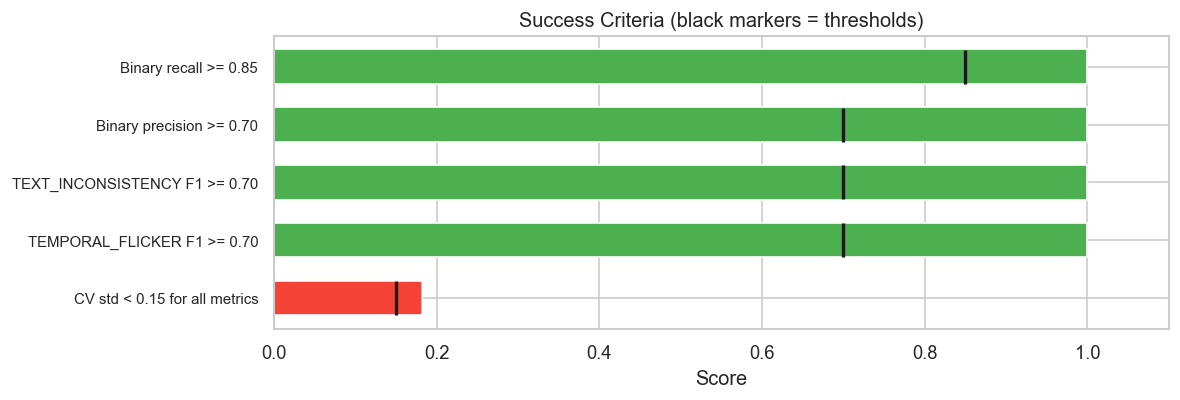

In [9]:
# Horizontal bar chart with threshold markers
metric_names = [row["Criterion"] for row in criteria_rows]
metric_values = [float(row["Value"]) for row in criteria_rows]
thresholds = [row["Threshold"] for row in criteria_rows]
passed = [row["Status"] == "PASS" for row in criteria_rows]

fig, ax = plt.subplots(figsize=(10, 3.5))
y_pos = range(len(metric_names))
bar_colors = ["#4CAF50" if p else "#F44336" for p in passed]

ax.barh(y_pos, metric_values, color=bar_colors, edgecolor="white", height=0.6)

# Threshold markers
for i, (thresh, name) in enumerate(zip(thresholds, metric_names)):
    # For CV std, the threshold is an upper bound
    ax.plot(thresh, i, "k|", markersize=20, markeredgewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(metric_names, fontsize=9)
ax.set_xlabel("Score")
ax.set_title("Success Criteria (black markers = thresholds)")
ax.set_xlim(0, 1.1)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

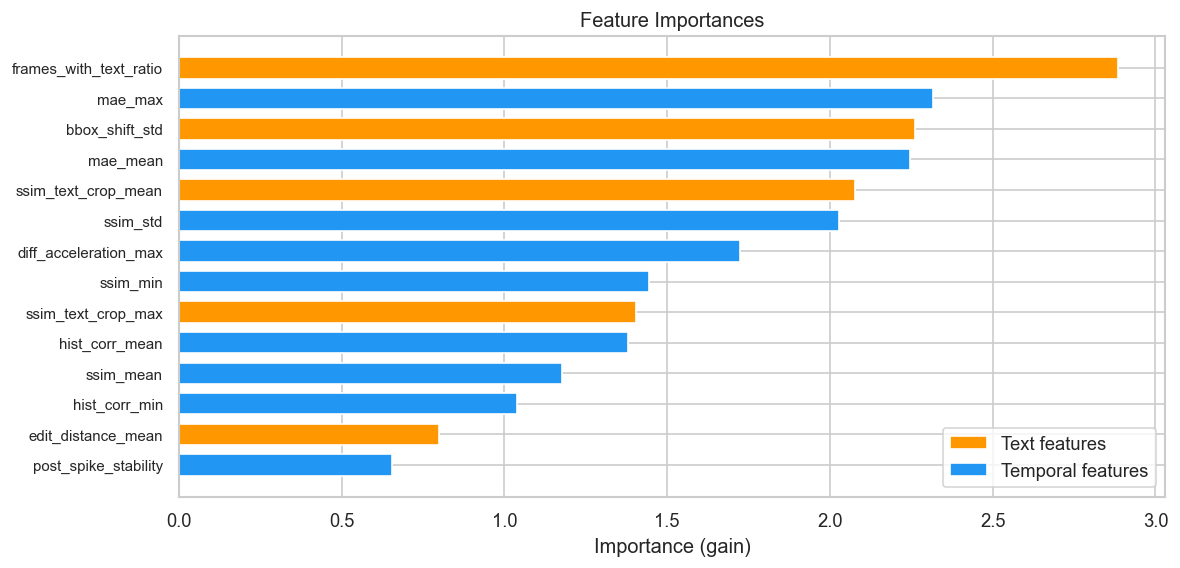

14 features with non-zero importance out of 43 total


In [10]:
# Sort by importance
sorted_feats = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
feat_names = [f[0] for f in sorted_feats]
feat_values = [f[1] for f in sorted_feats]

text_set = set(TEXT_FEATURE_NAMES)
temporal_set = set(TEMPORAL_FEATURE_NAMES)

feat_colors = []
for name in feat_names:
    if name in text_set:
        feat_colors.append("#FF9800")  # orange = text
    elif name in temporal_set:
        feat_colors.append("#2196F3")  # blue = temporal
    else:
        feat_colors.append("#9E9E9E")  # grey = unknown

fig, ax = plt.subplots(figsize=(10, max(4, len(feat_names) * 0.35)))
y_pos = range(len(feat_names))
ax.barh(y_pos, feat_values, color=feat_colors, edgecolor="white", height=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(feat_names, fontsize=9)
ax.set_xlabel("Importance (gain)")
ax.set_title("Feature Importances")
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#FF9800", label="Text features"),
    Patch(facecolor="#2196F3", label="Temporal features"),
]
ax.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.show()

print(f"{len(sorted_feats)} features with non-zero importance out of {len(COMBINED_FEATURE_NAMES)} total")

## 7. Example Predictions

In [11]:
# Pick one representative clip per true category
examples = []
for category in CLASS_ORDER:
    subset = pred_df[pred_df["true_label"] == category]
    if len(subset) > 0:
        examples.append(subset.iloc[0])

for ex in examples:
    status = "Correct" if ex["correct"] else "WRONG"
    print(f"--- {ex['clip']} ---")
    print(f"  True: {ex['true_label']}  |  Predicted: {ex['pred_label']}  [{status}]")
    print(f"  P(NONE)={ex['P(NONE)']:.3f}  P(TEXT)={ex['P(TEXT)']:.3f}  P(FLICKER)={ex['P(FLICKER)']:.3f}")
    print(f"  Confidence: {ex['confidence']:.3f}")
    if ex["override"]:
        print(f"  Override: {ex['override']}")
    print()

--- samples/clean_text_011.mp4 ---
  True: NONE  |  Predicted: NONE  [Correct]
  P(NONE)=0.926  P(TEXT)=0.039  P(FLICKER)=0.035
  Confidence: 0.926

--- samples/text_001.mp4 ---
  True: TEXT_INCONSISTENCY  |  Predicted: TEXT_INCONSISTENCY  [Correct]
  P(NONE)=0.243  P(TEXT)=0.651  P(FLICKER)=0.106
  Confidence: 0.651

--- samples/flicker_006.mp4 ---
  True: TEMPORAL_FLICKER  |  Predicted: TEMPORAL_FLICKER  [Correct]
  P(NONE)=0.237  P(TEXT)=0.124  P(FLICKER)=0.639
  Confidence: 0.639



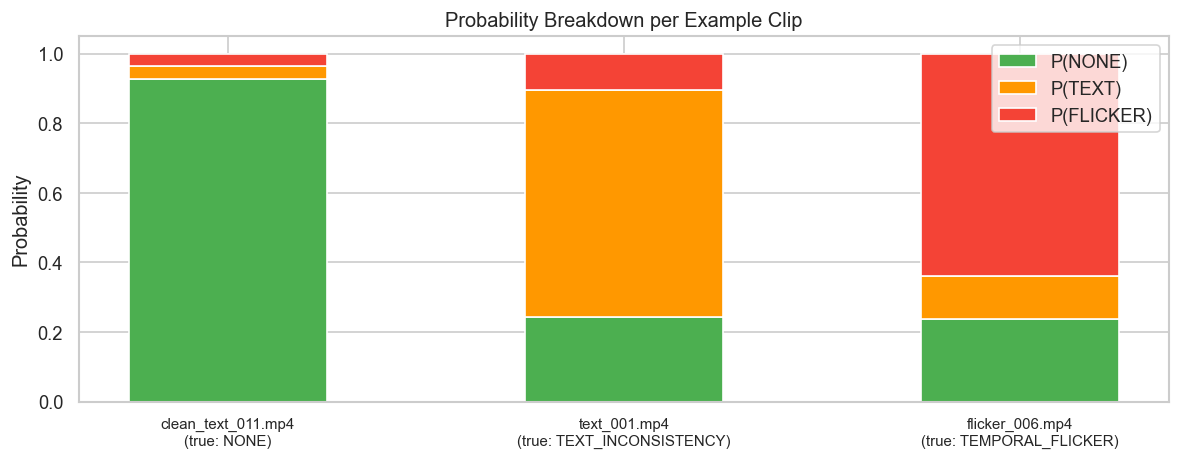

In [12]:
# Stacked bar chart of probability breakdown per example
fig, ax = plt.subplots(figsize=(10, 4))

clip_labels = [f"{ex['clip'].split('/')[-1]}\n(true: {ex['true_label']})" for ex in examples]
x = np.arange(len(examples))
width = 0.5

p_none = [ex["P(NONE)"] for ex in examples]
p_text = [ex["P(TEXT)"] for ex in examples]
p_flicker = [ex["P(FLICKER)"] for ex in examples]

ax.bar(x, p_none, width, label="P(NONE)", color=CLASS_COLORS["NONE"])
ax.bar(x, p_text, width, bottom=p_none, label="P(TEXT)", color=CLASS_COLORS["TEXT_INCONSISTENCY"])
ax.bar(x, p_flicker, width, bottom=[a + b for a, b in zip(p_none, p_text)],
       label="P(FLICKER)", color=CLASS_COLORS["TEMPORAL_FLICKER"])

ax.set_ylabel("Probability")
ax.set_title("Probability Breakdown per Example Clip")
ax.set_xticks(x)
ax.set_xticklabels(clip_labels, fontsize=9)
ax.set_ylim(0, 1.05)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

## 8. Probability Distributions

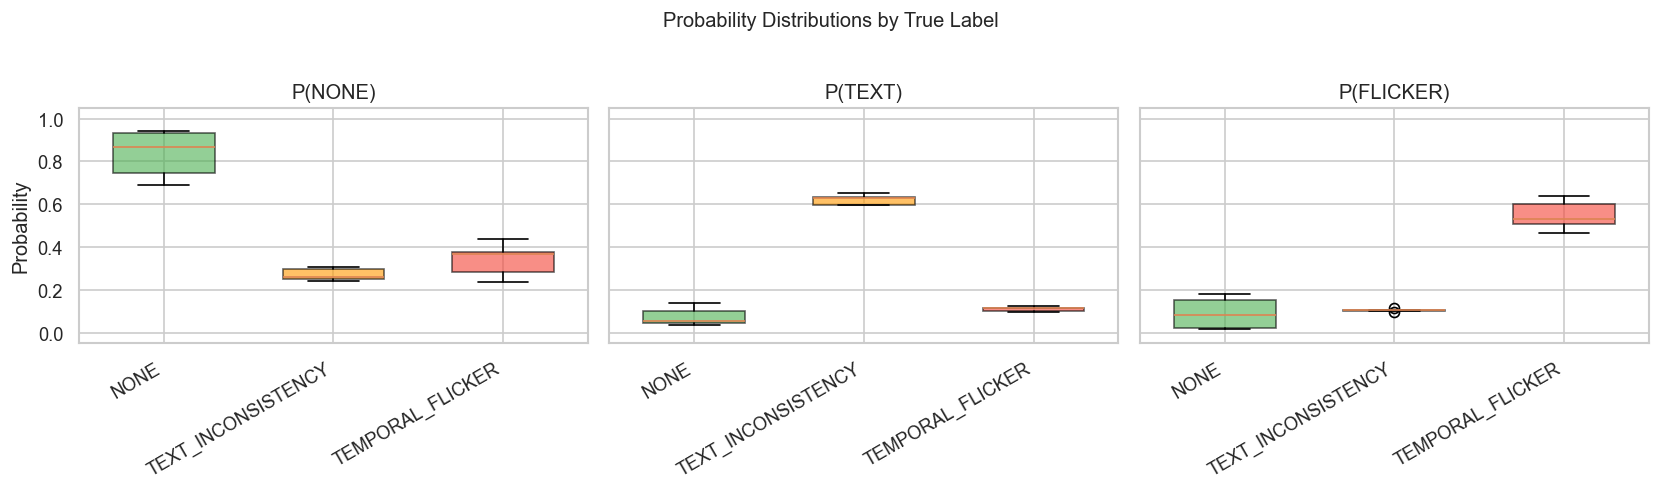

In [13]:
# Box plots: 3 panels (one per probability), grouped by true label
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

prob_cols = [("P(NONE)", "NONE"), ("P(TEXT)", "TEXT_INCONSISTENCY"), ("P(FLICKER)", "TEMPORAL_FLICKER")]

for ax, (col, class_name) in zip(axes, prob_cols):
    data_for_plot = []
    colors_for_plot = []
    for true_label in CLASS_ORDER:
        subset = pred_df[pred_df["true_label"] == true_label][col]
        data_for_plot.append(subset.values)
        colors_for_plot.append(CLASS_COLORS[true_label])

    bp = ax.boxplot(data_for_plot, patch_artist=True, widths=0.6)
    ax.set_xticks(range(1, len(CLASS_ORDER) + 1))
    ax.set_xticklabels(CLASS_ORDER, rotation=30, ha="right")
    for patch, color in zip(bp["boxes"], colors_for_plot):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax.set_title(f"{col}")
    ax.set_ylim(-0.05, 1.05)

axes[0].set_ylabel("Probability")
fig.suptitle("Probability Distributions by True Label", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

In [14]:
# Full prediction table with correctness highlighting
display_cols = ["clip", "true_label", "pred_label", "P(NONE)", "P(TEXT)", "P(FLICKER)", "confidence", "correct"]
table_df = pred_df[display_cols].copy()
table_df["clip"] = table_df["clip"].apply(lambda x: x.split("/")[-1])
table_df[["P(NONE)", "P(TEXT)", "P(FLICKER)", "confidence"]] = (
    table_df[["P(NONE)", "P(TEXT)", "P(FLICKER)", "confidence"]].round(3)
)

def highlight_correct(row):
    color = "background-color: #E8F5E9" if row["correct"] else "background-color: #FFEBEE"
    return [color] * len(row)

styled_table = table_df.style.apply(highlight_correct, axis=1).hide(axis="index")
display(styled_table)

accuracy = pred_df["correct"].mean()
print(f"\nOverall accuracy: {accuracy:.1%} ({pred_df['correct'].sum()}/{len(pred_df)})")

clip,true_label,pred_label,P(NONE),P(TEXT),P(FLICKER),confidence,correct
text_001.mp4,TEXT_INCONSISTENCY,TEXT_INCONSISTENCY,0.243000,0.651000,0.106000,0.651000,True
text_002.mp4,TEXT_INCONSISTENCY,TEXT_INCONSISTENCY,0.262000,0.635000,0.103000,0.635000,True
text_003.mp4,TEXT_INCONSISTENCY,TEXT_INCONSISTENCY,0.298000,0.595000,0.106000,0.595000,True
text_004.mp4,TEXT_INCONSISTENCY,TEXT_INCONSISTENCY,0.253000,0.631000,0.116000,0.631000,True
text_005.mp4,TEXT_INCONSISTENCY,TEXT_INCONSISTENCY,0.308000,0.594000,0.098000,0.594000,True
flicker_006.mp4,TEMPORAL_FLICKER,TEMPORAL_FLICKER,0.237000,0.124000,0.639000,0.639000,True
flicker_007.mp4,TEMPORAL_FLICKER,TEMPORAL_FLICKER,0.375000,0.117000,0.508000,0.508000,True
flicker_008.mp4,TEMPORAL_FLICKER,TEMPORAL_FLICKER,0.284000,0.116000,0.600000,0.600000,True
flicker_009.mp4,TEMPORAL_FLICKER,TEMPORAL_FLICKER,0.365000,0.103000,0.532000,0.532000,True
flicker_010.mp4,TEMPORAL_FLICKER,TEMPORAL_FLICKER,0.439000,0.095000,0.466000,0.466000,True



Overall accuracy: 100.0% (30/30)


## 9. Latency Analysis

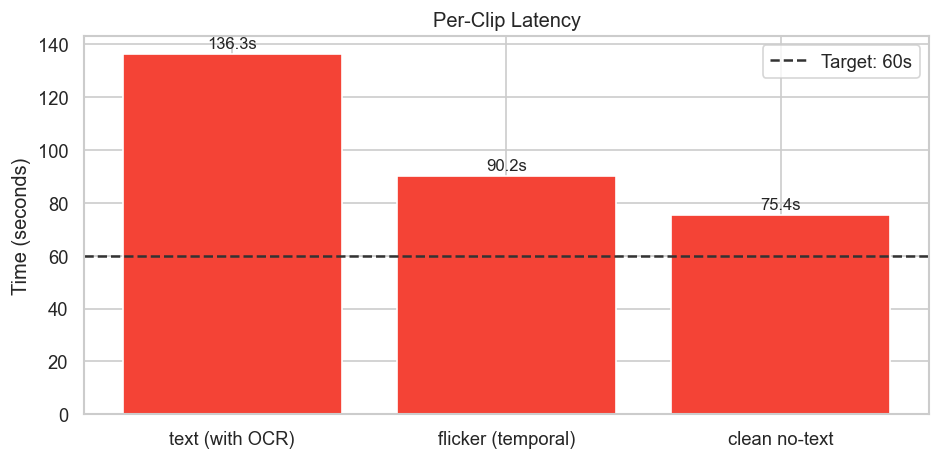

Average: 100.6s
Target:  60s
Passed:  False


In [15]:
if latency_data:
    clips = latency_data["clips"]
    clip_names = [c["clip"] for c in clips]
    times = [c["time_sec"] for c in clips]
    target = latency_data.get("target_sec", 60)

    fig, ax = plt.subplots(figsize=(8, 4))
    bar_colors = ["#4CAF50" if t <= target else "#F44336" for t in times]
    bars = ax.bar(clip_names, times, color=bar_colors, edgecolor="white")

    # Target line
    ax.axhline(target, color="#333333", linestyle="--", linewidth=1.5, label=f"Target: {target}s")

    for bar, t in zip(bars, times):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                f"{t:.1f}s", ha="center", va="bottom", fontsize=10)

    ax.set_ylabel("Time (seconds)")
    ax.set_title("Per-Clip Latency")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"Average: {latency_data['average_sec']:.1f}s")
    print(f"Target:  {target}s")
    print(f"Passed:  {latency_data['passed']}")
else:
    print("No latency benchmark data found.")

## 10. Summary

### Key Findings
- The XGBoost 3-class classifier was trained on **30 synthetic clips** with **43 features** (29 text + 14 temporal).
- Cross-validation shows **high variance** across folds (some folds at 1.0, others at 0.63), typical for small datasets.
- Feature importance is dominated by a mix of text and temporal features, confirming both feature groups contribute to discrimination.

### Known Limitations
- **Synthetic data only**: All clips are synthetically generated. Performance on real AI-generated video (Sora, Veo3) may differ significantly.
- **Latency**: End-to-end prediction exceeds the 60s target due to OCR overhead. This is expected for v0.1 on CPU.
- **CV variance**: std > 0.15 indicates the model is sensitive to fold composition. More data is needed.

### Next Steps
1. Collect real AI-generated clips (Milestone 6) and retrain on mixed dataset.
2. Evaluate domain gap between synthetic and real feature distributions.
3. Follow fallback strategy (SPEC.md section 6.5) if success criteria remain unmet on real data.